In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect = True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1df56c955f8>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
session.query(Measurement.date).order_by(Measurement.date.desc()).first()
query_date = dt.date(2017,8,23) - dt.timedelta(days = 365)
# Perform a query to retrieve the data and precipitation scores
date_results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()


In [13]:
#Load the query results into a Pandas DataFrame and set the index to the date column. Second Try
data = pd.DataFrame(date_results, columns = ['date', 'prcp'])
data.set_index('date', inplace = True)
data.sort_index(inplace = True)


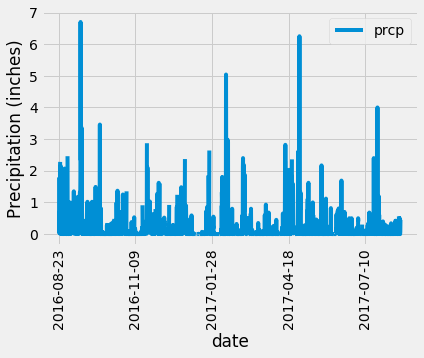

In [14]:
#Plot the results using the DataFrame `plot` method. 
data.plot(rot = 90)
plt.ylabel("Precipitation (inches)")
plt.show()

In [15]:
data.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
#station_count = session.query(Station).count()
#print(station_count)

unique_stations = session.query(Measurement.station).distinct().count()
print(unique_stations)

9


In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.id)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).\
        filter_by(station = 'USC00519281').first()
highest_temp = session.query(func.max(Measurement.tobs)).\
        filter_by(station = 'USC00519281').first()
avg_temp = session.query(func.avg(Measurement.tobs)).\
        filter_by(station = 'USC00519281').first()
print(lowest_temp, highest_temp, avg_temp)

(54.0,) (85.0,) (71.66378066378067,)


In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.date >= query_date).\
    filter(Measurement.station == 'USC00519281').all()

In [20]:
temp_df = pd.DataFrame(temp_results, columns = ("Date", "Temperature"))
temp_df.head()

,Date,Temperature
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


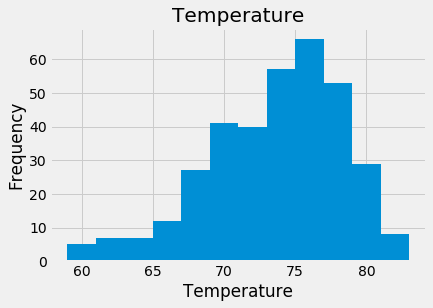

In [21]:
#plot results as histogram
hist = temp_df.hist(column = ["Temperature"], bins=12)
plt.ylabel("Frequency")
plt.xlabel("Temperature")
plt.show()

## Bonus Challenge Assignment

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [23]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
# trip is from March 3 - March 10
trip = calc_temps('2017-03-03', '2017-03-10')
print(trip)

[(62.0, 70.18367346938776, 78.0)]


In [24]:
result = list(np.ravel(trip))
result[0]

62.0

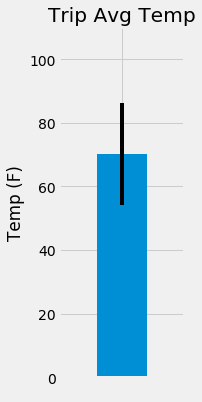

In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = " "
plt.figure(figsize=(2,6))
plt.bar(x_axis,height=result[1], yerr = (result[2]-result[0]), align = 'center')
plt.title("Trip Avg Temp")
plt.ylabel("Temp (F)")
plt.xlim(-1, 1)
plt.ylim (0, 110)
plt.show()

In [26]:
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1df585efa58>,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'station': 'USC00519397',
 'elevation': 3.0,
 'latitude': 21.2716,
 'id': 1}

In [27]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_start = dt.date(2017,3,3)
trip_end = dt.date(2017,3,10)
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.station, func.sum(Measurement.prcp), Station.name, Station.latitude, Station.longitude, Station.elevation]

trip_rainfall = session.query(*sel).filter(Measurement.station == Station.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    group_by(Measurement.station).\
    order_by(func.sum(Measurement.prcp).desc()).all()

In [28]:
station_precip = pd.DataFrame(trip_rainfall, columns = ['station_id', 'total precipitation', 'station_name', 'lat', 'lon', 'elev'])
station_precip = station_precip[['station_id', 'station_name', 'total precipitation', 'lat', 'lon', 'elev']]
station_precip

,station_id,station_name,total precipitation,lat,lon,elev
0,USC00513117,"KANEOHE 838.1, HI US",2.08,21.42340,-157.80150,14.6
1,USC00519281,"WAIHEE 837.5, HI US",1.39,21.45167,-157.84889,32.9
2,USC00516128,"MANOA LYON ARBO 785.2, HI US",0.92,21.33310,-157.80250,152.4
3,USC00519397,"WAIKIKI 717.2, HI US",0.82,21.27160,-157.81680,3.0
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.63,21.52130,-157.83740,7.0
5,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.25,21.33556,-157.71139,19.5
6,USC00517948,"PEARL CITY, HI US",0.14,21.39340,-157.97510,11.9


In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [64]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = dt.date(2017,3,3)
no_days=7
# Use the start and end date to create a range of dates
date_list = [(start_date + dt.timedelta(days = day)) for day in range(no_days)]
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [92]:
formatted_date_list = ["03-03", "03-04","03-05", "03-06", "03-07", "03-08", "03-09", "03-10"]
normals=[]
for date in formatted_date_list:
    normals.append(daily_normals(date))

normal_list=[]
for item in normals:
    normal_list.append(list(np.ravel(item)))

normal_list

[[60.0, 70.06896551724138, 78.0],
 [57.0, 69.27272727272727, 77.0],
 [60.0, 67.89090909090909, 76.0],
 [60.0, 69.20338983050847, 76.0],
 [60.0, 69.17241379310344, 78.0],
 [59.0, 68.72413793103448, 78.0],
 [57.0, 68.56140350877193, 75.0],
 [57.0, 69.12280701754386, 75.0]]

In [98]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_df = pd.DataFrame(normal_list, columns=("Tmin", "Tavg", "Tmax"), index=formatted_date_list)
trip_df

,Tmin,Tavg,Tmax
03-03,60.0,70.068966,78.0
03-04,57.0,69.272727,77.0
03-05,60.0,67.890909,76.0
03-06,60.0,69.203390,76.0
03-07,60.0,69.172414,78.0
03-08,59.0,68.724138,78.0
03-09,57.0,68.561404,75.0
03-10,57.0,69.122807,75.0


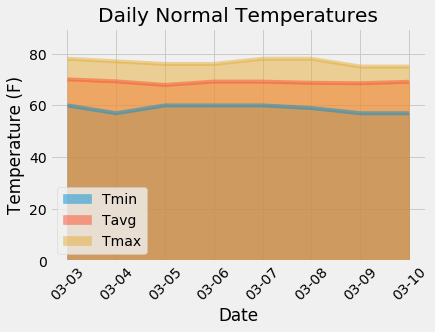

In [99]:
# Plot the daily normals as an area plot with `stacked=False`
trip_df.plot(kind="area", stacked=False, rot =45)
plt.title("Daily Normal Temperatures")
plt.ylabel("Temperature (F)")
plt.xlabel("Date")
plt.ylim(0,90)
plt.show()